<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros

**Nombres:**
Mateo Verea Dorantes,
Alejandra Rico Rosales

**Fecha:** 26 de noviembre de 2021

**Expediente** : 
    if709396, 720838
    
**Profesor:** Oscar David Jaramillo Zuluaga
    
**Link Github**:https://github.com/Mateoverea/Tarea10_MVerea_ARico
    
# Tarea 10

Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:
1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price usando la volatility smile vista en la clase de opciones europeas y basado en el spot price y el strike defina una barrera adecuada.

In [42]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

#### Código de solución `ESTUDIANTE 1: MATEO VEREA`

Decidí hacer este ejercicio con la acción NFLX por su comportamiento a la alza de los últimos años y su tendencia actual.

In [48]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [49]:
closes = get_adj_closes(['NFLX'], '2017-01-01')
closes_nflx = closes.loc[:,'NFLX']
closes_nflx

Date
2017-01-03    127.49
2017-01-04    129.41
2017-01-05    131.81
2017-01-06    131.07
2017-01-09    130.95
               ...  
2021-11-19    678.80
2021-11-22    659.20
2021-11-23    654.06
2021-11-24    658.29
2021-11-26    665.64
Name: NFLX, Length: 1235, dtype: float64

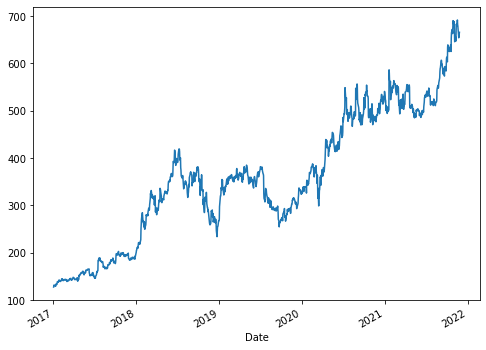

In [50]:
closes_nflx.plot(figsize=(8,6));

In [51]:
closes_nflx[-1]

665.6400146484375

In [52]:
ret_nflx = calc_daily_ret(closes_nflx)

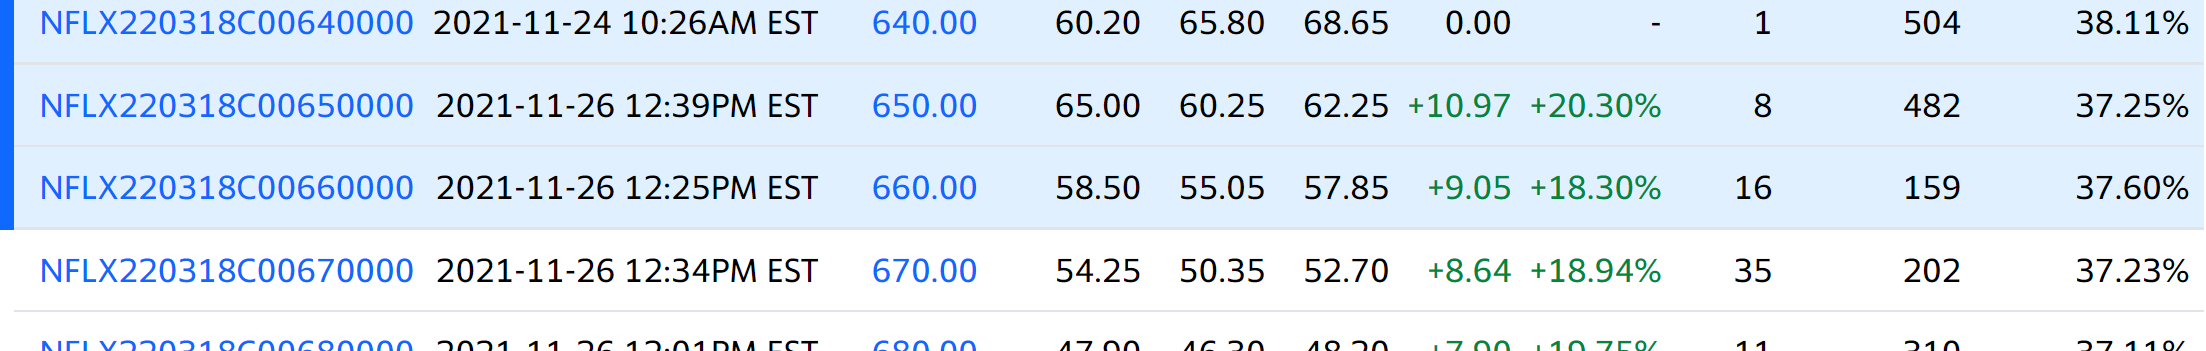

Usamos la de 660

In [68]:
mu = ret_nflx.mean()
sigma = ret_nflx.std()
r = 0.0021/360
mu, sigma, r

(0.0013393120684503412, 0.024062126495148467, 5.833333333333333e-06)

### Simulación de precios

In [57]:
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = '2022/03/18'

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = 660
S0 = closes_nflx.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

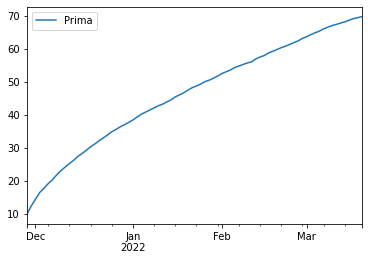

In [58]:
strike = K
call=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0).mean(axis=1)}, index=dates)
call.plot();

In [59]:
call.iloc[-1]

Prima    69.699
Name: 2022-03-18 00:00:00, dtype: float64

In [60]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(66.77410448035958, 72.62435131052341)


### Histograma de rendimientos

In [62]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_nflx-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [63]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())
sim_closes_hist.iloc[0,:] = S0

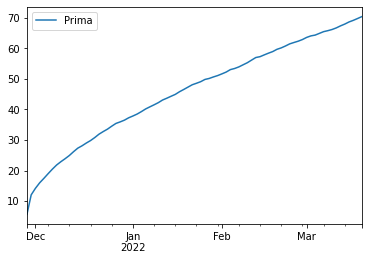

In [64]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();

In [65]:
call_hist.iloc[-1]

Prima    70.437
Name: 2022-03-18 00:00:00, dtype: float64

In [66]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = call_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(67.49391735514307, 73.37957754133056)


El valor actual de la opcion no es muy lejano al intervalo de confianza, podemos deducir que es confiable.

### Valuación down and out y up and out

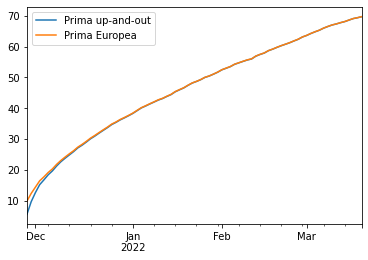

In [75]:
# Definir barrera
B = 680
# Crear función indicadora
I = (sim_closes > B).cumsum(axis=0) > 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima up-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - strike, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = callui.plot();
call.plot(ax=ax);

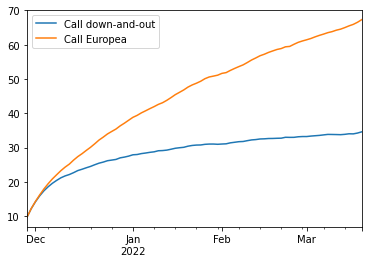

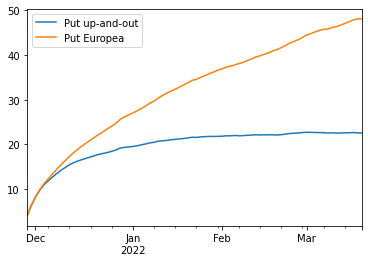

In [79]:
bu = 690
bd = 640
mu = 0.001
sigma = 0.024
opciones_barrera(S0, 660, mu, sigma, expiry, bu=bu, bd=bd)

En ambos casos la ganancia por utilizar una función barrera es útil, se logra reducir el precio y tener más facilidad de vender con mayor ganancia.

#### Código de solución `ESTUDIANTE 2: ALEJANDRA RICO`

In [71]:
####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

# Definir barrera

def opciones_barrera(s, k, mu, sigma, expiry, bu = 0, bd = 0, n_sim = 10000):
    
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq='B')
    ndays = len(dates)
    sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,n_sim)+r,index=dates)
    sim_closes = S0*np.exp(sim_ret.cumsum())
    
# 'CALL'- down-and-out
# 'PUT'- up-and-out 

    # Calcular la prima de una opción Europea
    call = pd.DataFrame({'Call Europea':np.exp(-r*ndays)*np.fmax(sim_closes - k, 0)
                         .mean(axis=1)},index=dates)
    put = pd.DataFrame({'Put Europea':np.exp(-r*ndays)*np.fmax(k - sim_closes, 0)
                     .mean(axis=1)},index=dates)

    # CALL OPTIONS 
    
    I = (sim_closes < bd).cumsum(axis=0) == 0
    calldo = pd.DataFrame({'Call down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
                       .mean(axis=1)},index=dates)   
    
       # PUT OPTIONS 
        
    I = (sim_closes > bu).cumsum(axis=0) == 0
    putuo = pd.DataFrame({'Put up-and-out':np.exp(-r*ndays)*(I * np.fmax(k - sim_closes, 0))
                       .mean(axis=1)},index=dates)
    
      
        
    # Graficar el resultado de las dos primas previamente valuadas
    ax = calldo.plot();
    call.plot(ax=ax);
    
    ax = putuo.plot();
    put.plot(ax=ax);

In [3]:
import yfinance as yf
data = yf.download('MSFT', start="2017-01-01", end="2021-11-24")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,62.79,62.84,62.13,62.58,58.186,20694100
2017-01-04,62.48,62.75,62.12,62.30,57.925,21340000
2017-01-05,62.19,62.66,62.03,62.30,57.925,24876000
2017-01-06,62.30,63.15,62.04,62.84,58.427,19922900
2017-01-09,62.76,63.08,62.54,62.64,58.241,20382700
...,...,...,...,...,...,...
2021-11-17,338.94,342.19,338.00,339.12,339.120,19053400
2021-11-18,338.18,342.45,337.12,341.27,341.270,22463500
2021-11-19,342.64,345.10,342.20,343.11,343.110,21942200


In [4]:
closes_msft = data.iloc[:, [4]]
closes_msft

,Adj Close
Date,
2017-01-03,58.186
2017-01-04,57.925
2017-01-05,57.925
2017-01-06,58.427
2017-01-09,58.241
...,...
2021-11-17,339.120
2021-11-18,341.270
2021-11-19,343.110


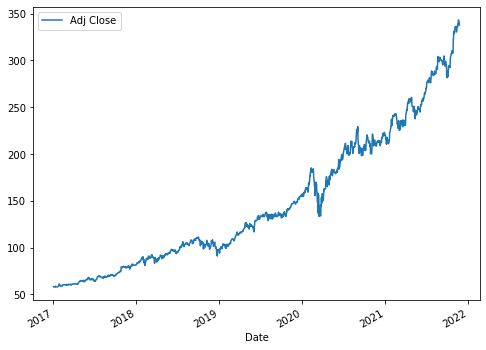

In [5]:
closes_msft.plot(figsize=(8,6));

In [6]:
closes_msft.iloc[-1]

Adj Close    337.68
Name: 2021-11-23 00:00:00, dtype: float64

In [7]:
# Rendimientos
ret_msft = calc_daily_ret(closes_msft)
ret_msft

,Adj Close
Date,
2017-01-04,-4.484e-03
2017-01-05,0.000e+00
2017-01-06,8.630e-03
2017-01-09,-3.188e-03
2017-01-10,-3.193e-04
...,...
2021-11-17,6.784e-04
2021-11-18,6.320e-03
2021-11-19,5.377e-03


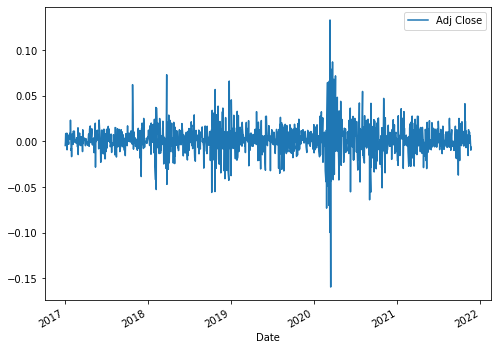

In [8]:
ret_msft.plot(figsize=(8,6));

> Tomamos una opción con fecha de expiración al 21 de enero 2022. El precio actual del activo es de 337.68, y al ver que va a la alsa tomaremos una opción con un strick price superior, 340: `MSFT220121C00340000`

<img src='op.jpg'>

### Simulación de Precios 

In [9]:
mu = ret_msft.mean()
sigma = ret_msft.std()
r = 0.0021/360
mu, sigma, r

(Adj Close    0.001
 dtype: float64,
 Adj Close    0.017
 dtype: float64,
 5.833333333333333e-06)

In [11]:
from datetime import date
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = '2022-01-21'

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = 340
S0 = 337.68
sim_ret = pd.DataFrame(0.017*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = 337.68*np.exp(sim_ret.cumsum())
sim_closes.iloc[0,:] = S0
sim_closes

,0,1,2,...,9997,9998,9999
2021-11-26,337.680,337.680,337.680,...,337.680,337.680,337.680
2021-11-29,328.667,344.149,357.268,...,342.648,341.152,330.356
2021-11-30,332.369,348.689,364.719,...,342.096,332.530,322.746
2021-12-01,334.141,347.055,386.010,...,353.513,327.503,314.438
2021-12-02,330.096,345.607,391.170,...,335.633,332.195,305.525
...,...,...,...,...,...,...,...
2022-01-17,335.296,346.848,377.184,...,254.076,311.872,282.625
2022-01-18,333.106,349.377,368.125,...,256.527,310.762,278.895
2022-01-19,331.563,343.789,365.206,...,263.795,306.748,277.441
2022-01-20,326.855,346.556,359.799,...,268.073,307.598,278.428


### Valuación de la opción (Europea)

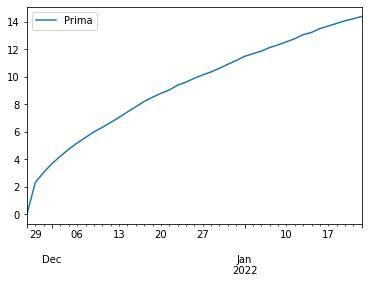

In [12]:
strike = K
call = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0).mean(axis=1)}, index=dates)
call.plot();

In [13]:
call.iloc[-1]

Prima    14.392
Name: 2022-01-21 00:00:00, dtype: float64

In [14]:
# intervalo de confianza
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(13.674398768521405, 15.108968298277533)


### Histograma de Rendimientos 

In [15]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_msft-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [16]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())
sim_closes_hist.iloc[0,:] = S0

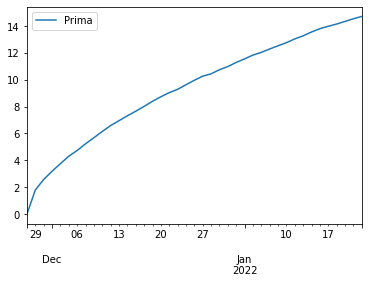

In [17]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();

In [18]:
call_hist.iloc[-1]

Prima    14.705
Name: 2022-01-21 00:00:00, dtype: float64

In [19]:
# intervalo de confianza
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = call_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(13.965908781991855, 15.444540682953539)


> El valor real de la opción que estamos valuando se encuentra muy cerca del intervalo de confianza, por lo que los resultado obtenidos son muy confiables.

### Valuación de metodo `down and out & up and out`

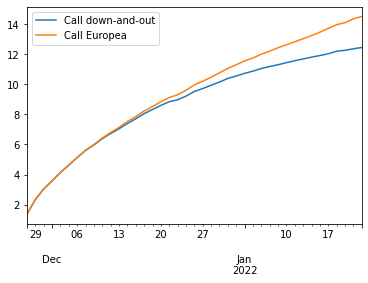

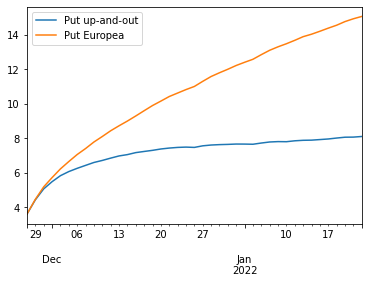

In [25]:
S0 = 337.68
expiry = '2022-01-21'
bu = 345 #put 
bd = 320 #call
mu = 0.001
sigma = 0.017
opciones_barrera(S0, K, mu, sigma, expiry, bu=bu, bd=bd)

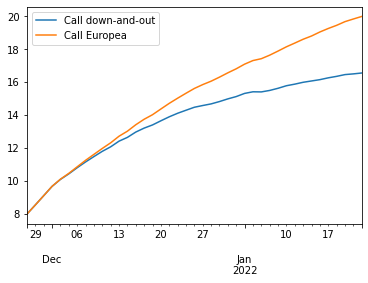

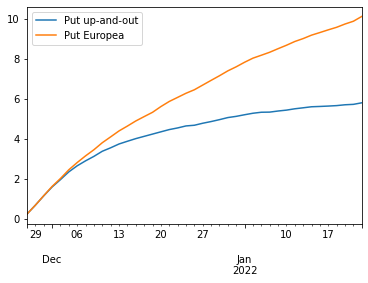

In [27]:
s0 = 337.68
mu = 0.001
sigma = 0.017
bu = 345 #put
bd = 320 #call 
opciones_barrera(S0, 330, mu, sigma, expiry, bu=bu, bd=bd)

> La opción `barrera call` seria muy buena alternativa al buscar comprar acciones de Microsoft porque logra abaratar el precio de la prima. 

> La opción `barrera put` facilitaría una ganancia en caso de necesitar vender dicha accion.